# White features vs Mag (HST Training Set)

In this notebook we show the distribution of 11 white features, 
which we used for constructing the machine learning model, 
as a function of magnitude for sources from PS1xHST-COSMOS cross-matched catalog. 
The distribution of wwpsfKronDist shows that wwpsfKronDist itself do a good job even at the faint end. 

For obtaining a reasonable kernel density estimation (KDE), 
we excluded outliers by $10 < wwKronMag < 25$, $0 < wwPSFKronRatio < 2$, 
and $-10^{-3} < wwPSFKronDist < 10^{-3}$ from sources with $nDetection > 0$. 

In [1]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
%matplotlib inline
from matplotlib import cm
from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.special import expit
from scipy import stats

In [2]:
ff_tab = Table.read("/home/xhall/Documents/PS1CrossMatch/PS1_star_galaxy.adamamiller.HST_COSMOS_Forcefeatures_xhall.fit").to_pandas()

In [3]:
ff_tab

,CLASS_STAR,MU_CLASS,objid,raStack,decStack,nDetections,qualityFlag,iFPSFminusFKron,wwFPSFFlux,wwFKronFlux,wwFApFlux,wwE1,wwE2,wwFPSFKronDist,wwFPSFApDist,wwFPSFApRatio,wwFPSFKronRatio
0,0.000725,1,109881495850127689,149.585018,1.572709,0,48,0.292608,0.000004,0.000005,0.000005,0.183145,-0.319997,9.164235e-08,2.821370e-07,0.852816,0.778531
1,0.000252,1,109881495921147257,149.592128,1.572349,0,160,1.223340,0.000002,0.000004,0.000003,-0.172711,0.030975,-1.168007e-06,-5.674658e-07,0.539249,0.397937
2,0.028073,1,109881495927824692,149.592723,1.570180,10,53,-0.180435,0.000003,0.000003,0.000004,-10.263180,7.358432,3.484819e-07,2.166814e-07,0.856035,0.885392
3,0.000382,1,109881495945249941,149.594528,1.574586,0,48,0.255548,0.000004,0.000005,0.000005,0.042899,0.174690,-1.474906e-07,-3.055548e-08,0.770168,0.722516
4,0.027856,1,109881495969889066,149.597023,1.573850,16,52,0.300032,0.000010,0.000011,0.000013,0.062939,-0.129570,1.412731e-06,-2.761108e-07,0.750748,0.924985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80860,0.020991,1,111461504005643211,150.400566,2.885622,0,160,NaN,0.000006,0.000028,0.000015,-0.025538,0.043532,-1.203978e-05,-4.386261e-06,0.396886,0.209720
80861,0.978174,2,111461504021031601,150.402125,2.884301,90,20,-0.088221,0.000073,0.000055,0.000072,-0.009370,0.010829,2.535490e-05,1.334161e-05,1.011362,1.337744
80862,0.000357,1,111461504113292118,150.411312,2.884708,11,52,0.202336,0.000003,0.000003,0.000004,-0.071619,-0.004240,5.877859e-07,1.892906e-07,0.838759,0.974317
80863,0.001057,1,111471500544651300,150.054465,2.892411,50,52,0.267523,0.000009,0.000013,0.000012,0.159429,0.042476,-9.366961e-07,-6.108370e-07,0.713920,0.666106


The crossmatched catalog contains 75,927 sources. 

In [4]:
star, galaxy = ff_tab.MU_CLASS == 2, ff_tab.MU_CLASS == 1

In [5]:
whiteKronMag = -2.5*np.log10(ff_tab.wwFKronFlux/3631)
whiteApMag = -2.5*np.log10(ff_tab.wwFApFlux/3631)

In [6]:
def kde_contour_dat(x, y, extent = 'Auto', bw_type = "silverman", grid_bins = 250, BW=False):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == 'Auto':
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])
    if BW:
        bw = BW

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

Selecting sources with nDetections > 0, and then exclude outlier to obtain a reasonable kernel density distribution. 

In [7]:
Det_mask = ff_tab.nDetections > 0 & np.isfinite(ff_tab.iFPSFminusFKron)
PsfApRatio_mask = np.logical_and(0<ff_tab.wwFPSFApRatio, ff_tab.wwFPSFApRatio<2)
ApMag_mask = np.logical_and(10<whiteApMag, whiteApMag<25)
PsfApDist_mask = np.logical_and(-1e-3<ff_tab.wwFPSFApDist, ff_tab.wwFPSFApDist<1e-3)

In [8]:
mask = Det_mask & PsfApRatio_mask & ApMag_mask & PsfApDist_mask

In [9]:
xgal_Ratio, ygal_Ratio, zgal_Ratio = kde_contour_dat(whiteApMag[mask&galaxy], ff_tab.wwFPSFApRatio[mask&galaxy])
xstar_Ratio, ystar_Ratio, zstar_Ratio = kde_contour_dat(whiteApMag[mask&star], ff_tab.wwFPSFApRatio[mask&star])

In [10]:
star_norm = len(ff_tab.loc[mask&star])*1.0/len(ff_tab.loc[mask])
galaxy_norm = len(ff_tab.loc[mask&galaxy])*1.0/len(ff_tab.loc[mask])

Although we used wwpsfCHiSq and wwpsdLikelyhood itself for training the machine learning model, we show the distribution of $\log_{10}(wwpsfChiSq)$ and $\log_{10}(|wwpsfLikelihood|)$ in the following figure just for visibility. 

In [11]:
np.percentile(ff_tab["wwFPSFApRatio"], (16,50,84))

array([0.55519552, 0.77789637, 1.03913695])

### The distribution of white features (except for wwpsfKornDist) 

0 0
0 1
0 2
0 3
0 4
0 0
1 1
1 2
1 3
1 4
1 0
1 1


/home/xhall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


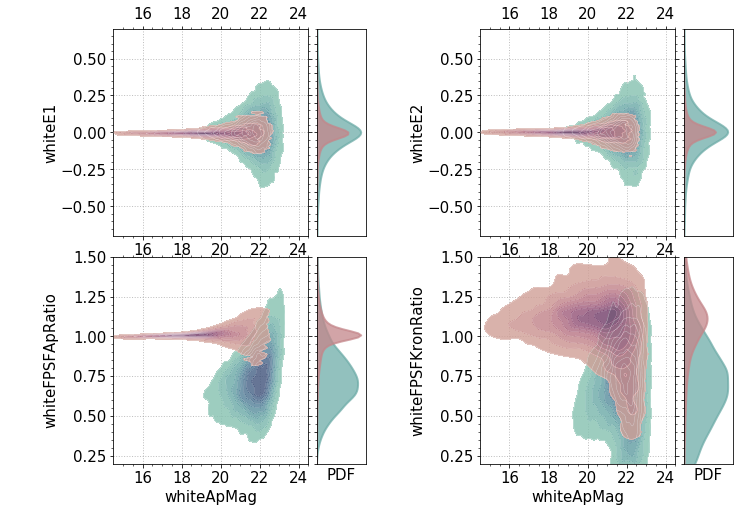

In [12]:
plt_feat = ['wwE1',  'wwE2', 'wwFPSFApRatio', 'wwFPSFKronRatio']
ylims_list = [[-.7, .7], [-.7, .7], [.2, 1.5], [.2, 1.5]]
num_feat = len(plt_feat)

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(int(num_feat/2), 6, width_ratios=(2, 4, 1, 2, 4, 1))
plt.figure(figsize=(13, 8))
plt.subplots_adjust(wspace=0.075, hspace=0.1)
ax = []
i = 0
for ind in range(6*int(num_feat/2)):
    print(i, ind%5)
    ax.append(plt.subplot(gs[i, ind%6]))
    if ind%6==5:
        i += 1
        if i == 5: 
            break

xlims = [14.5, 24.5]

row_num = 0
for i,name in enumerate(plt_feat):
    
    #ylims = np.percentile(ff_tab[name][mask], [1, 99])
    #print(ylims)
    ylims = ylims_list[i]
    
    #xkernel_size = (xlims[1] - xlims[0])/10
    #ykernel_size = (ylims[1] - ylims[0])/10
    
    xgal_, ygal_, zgal_ = kde_contour_dat(whiteApMag[mask&galaxy&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))], 
                                          ff_tab[name][mask&galaxy&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))], 
                                         extent = np.r_[xlims, ylims])
    xstar_, ystar_, zstar_ = kde_contour_dat(whiteApMag[mask&star&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))],
                                             ff_tab[name][mask&star&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))], 
                                            extent = np.r_[xlims, ylims])
    
    ax[row_num].text(-0.1,np.mean(ylims),name.replace('ww', 'white'), 
                     ha='center', va='center', rotation=90, fontsize=15)
    ax[row_num].set_xlim(-1, 1); ax[row_num].set_ylim(ylims)
    ax[row_num].axis('off')
    
    ax[row_num+1].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
    ax[row_num+1].set_axisbelow(True)
    ax[row_num+1].contourf(xgal_, ygal_, zgal_, levels = levels,
                 origin = origin,
                 cmap = cmap_gal, alpha = 0.8)
    ax[row_num+1].contour(xgal_, ygal_, zgal_, levels = levels,
                        linewidths=(0.5,), origin = origin,
                        colors = ("w",), alpha = 0.5, zorder = 11)
    ax[row_num+1].contourf(xstar_, ystar_, zstar_, levels = levels,  
                   origin = origin,
                   cmap = cmap_star, alpha = 0.8)
    ax[row_num+1].contour(xstar_, ystar_, zstar_, levels = levels,
                        linewidths=(0.5,), origin = origin,
                        colors = ("w",), alpha = 0.5, zorder = 11)  
    ax[row_num+1].set_xlim(xlims); ax[row_num].set_ylim(ylims)
    ax[row_num+1].tick_params(labelsize = 15)
    ax[row_num+1].tick_params(which='both', top=True, right=True)
    ax[row_num+1].set_xticks(np.arange(16, 26, 2))
    ax[row_num+1].minorticks_on()
    #ax[row_num+1].set_axisbelow(True)
    if i-len(plt_feat) >= -2:
        ax[row_num+1].set_xlabel('whiteApMag', fontsize=15)
    else: 
        ax[row_num+1].tick_params(labelbottom="off", labeltop='off')
        

    n = (np.arange(ylims[0]-np.abs(ylims[1]-ylims[0])*2, ylims[1]+np.abs(ylims[1]-ylims[0])*2, np.abs(ylims[1]-ylims[0])/100))
    #print(n)
    if ylims[0]<0:
        range_mask  = (ylims[0]*2 < ff_tab[name]) & (ff_tab[name] < ylims[1]*2)
    else: 
        range_mask  = (ylims[0]/2 < ff_tab[name]) & (ff_tab[name] < ylims[1]*2)
    kde_Star_ = stats.gaussian_kde(np.array(ff_tab[name][mask&star&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))&range_mask]), 
                                  bw_method='silverman')
    kde_Gal_ = stats.gaussian_kde(np.array(ff_tab[name][mask&galaxy&(~np.isnan(ff_tab[name]))&(~np.isinf(ff_tab[name]))&range_mask]), 
                                 bw_method='silverman')
    ax[row_num+2].fill_betweenx(n, kde_Gal_(n)*galaxy_norm, alpha=0.75, color=cmap_gal(0.25), lw=2)
    ax[row_num+2].fill_betweenx(n, kde_Star_(n)*star_norm, alpha=0.75, color=cmap_star(0.25), lw=2)
    ax[row_num+2].set_ylim(ylims)
    ax[row_num+2].set_xlim(0, 1.1*np.max(np.r_[kde_Gal_(n)*galaxy_norm, kde_Star_(n)*star_norm]))
    ax[row_num+2].set_xticklabels( () )
    ax[row_num+2].set_yticklabels( () )
    ax[row_num+2].set_xticks([])
    ax[row_num+2].tick_params(which='both', left='off')
    ax[row_num+2].minorticks_on()
    #ax[row_num+2].set_axisbelow(True)
    if i-len(plt_feat) >= -2:
        ax[row_num+2].set_xlabel('PDF', fontsize=15)
        
    row_num += 3
    
#plt.tight_layout()
plt.savefig('whiteFeatures.pdf', pad_inches=0.5)

### Correlation matrix of white features

In [92]:
wwfeatures = ['wwExtNSigma',
       'wwmomentYY', 'wwmomentXY', 'wwmomentXX', 'wwKronRad', 'wwmomentRH',
       'wwpsfChiSq', 'wwpsfLikelihood', 'wwPSFKronDist', 'wwPSFApRatio',
       'wwPSFKronRatio']

In [93]:
def delete_ww(str_array):
    string = ",".join(str_array)
    string_new = string.replace('ww', '')
    str_list_new =  string_new.split(",")
    return(str_list_new)

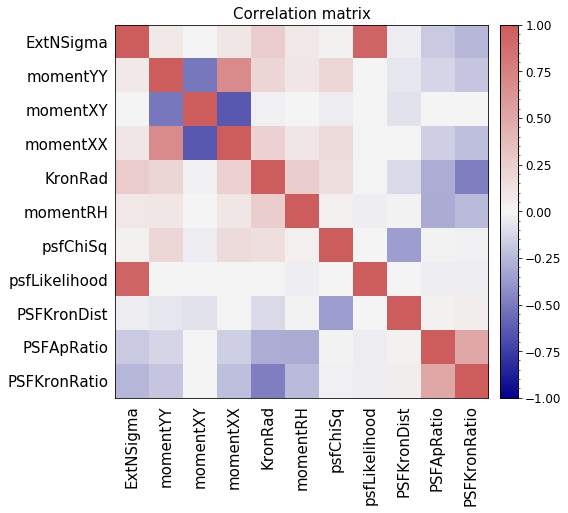

In [94]:
import mpl_toolkits.axes_grid1
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['darkblue',  'whitesmoke', 'indianred'])


def correlation_matrix(df):

    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    ax1.tick_params(bottom="off", left='off')
    cmap = cm
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
    #ax1.grid(True)
    plt.title('Correlation matrix', fontsize=15)
    labels=delete_ww(ff_tab[wwfeatures].columns.values)
    ax1.set_xticks(range(0, len(labels)))
    ax1.set_yticks(range(0, len(labels)))
    ax1.set_xticklabels(labels,fontsize=15, rotation =90)
    ax1.set_yticklabels(labels,fontsize=15)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
    cax_ = divider.append_axes('right', '5%', pad='3%')
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.25), cax=cax_).ax.tick_params(labelsize=12)
    plt.colorbar(cax, ticks=np.arange(-1, 1.25, 0.25), cax=cax_).ax.minorticks_on()
    plt.tight_layout()

correlation_matrix(ff_tab[wwfeatures])
plt.savefig('CorrelationMatrix.pdf', pad_inches=0.5)

ExtNSigma and psdLikelihood have relatively strong correlation, but the ML model constructed by the random forest algorithm should be insensitive to such correlation between training features. 

### Flux-flux plot and the best fit line for the psdKronDist (Simple model)

We constructed the star/galaxy separation model by using the wwPSFFlux and the wwKronFlux. 
The best threshold (maximizing the FoM) is $wwPSFFlux = 0.91375\times wwKronFlux$. 

In [8]:
whitePSFMag = -2.5*np.log10(ff_tab.wwPSFFlux/3631)
PSFMag_mask = np.logical_and(10<whitePSFMag, whitePSFMag<25)
mask = Det_mask & PsfKronRatio_mask & KronMag_mask & PsfKronDist_mask & PSFMag_mask

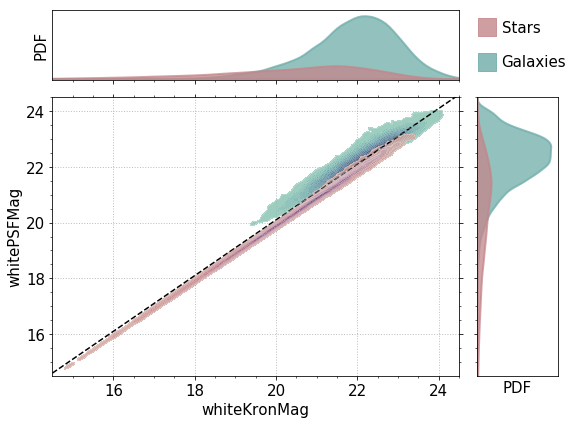

In [11]:
import matplotlib.colors

xgal_Ratio, ygal_Ratio, zgal_Ratio = kde_contour_dat(whiteKronMag[mask&galaxy], whitePSFMag[mask&galaxy], 
                                                     grid_bins=200, extent=(14.5, 24.5, 14.5, 24.5), BW=[0.05, 0.05])
xstar_Ratio, ystar_Ratio, zstar_Ratio = kde_contour_dat(whiteKronMag[mask&star], whitePSFMag[mask&star], 
                                                        grid_bins=200, extent=(14.5, 24.5, 14.5, 24.5), BW=[0.05, 0.05])

gridsize = 250
xlims = [14.5, 24.5]
ylims = [14.5, 24.5]

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

gs = grs.GridSpec(2, 2, width_ratios=(5, 1), height_ratios=(1, 4))
plt.figure(figsize=(8, 6))
ax = [plt.subplot(gs[1, 0]), plt.subplot(gs[1, 1]), plt.subplot(gs[0, 0]), plt.subplot(gs[0,1])]

ax[0].grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax[0].tick_params(which="both", top=True, right=True)
ax[0].minorticks_on()
ax[0].set_axisbelow(True)
"""
ax[0].hist2d(whiteKronMag[mask&galaxy], whitePSFMag[mask&galaxy], 
            bins=[np.linspace(14.5, 24.5, gridsize), np.linspace(14.5, 24.5, gridsize)], 
            norm=matplotlib.colors.LogNorm(), 
            cmap=cmap_gal, alpha=0.9)
ax[0].hist2d(whiteKronMag[mask&star], whitePSFMag[mask&star], 
            bins=[np.linspace(14.5, 24.5, gridsize), np.linspace(14.5, 24.5, gridsize)], 
            norm=matplotlib.colors.LogNorm(), 
            cmap=cmap_star, alpha=0.9)
"""  
ax[0].contourf(xgal_Ratio, ygal_Ratio, zgal_Ratio, levels = levels,
             origin = origin,
             cmap = cmap_gal, alpha = 0.8)
ax[0].contour(xgal_Ratio, ygal_Ratio, zgal_Ratio, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax[0].contourf(xstar_Ratio, ystar_Ratio, zstar_Ratio, levels = levels,  
               origin = origin,
               cmap = cmap_star, alpha = 0.8)
ax[0].contour(xstar_Ratio, ystar_Ratio, zstar_Ratio, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)

ax[0].set_xlim(xlims); ax[0].set_ylim(ylims)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('whiteKronMag', fontsize=15)
ax[0].set_ylabel('whitePSFMag', fontsize=15)
ax[0].plot(xlims, -2.5*np.log10(0.91375)+np.array(xlims), '--', color='k')
#ax[0].text(13, np.mean(ylims), 'whitePSFKronRatio', va='center', rotation='vertical', fontsize=15)


n = (np.arange(ylims[0]-1, ylims[1]+1,0.005))
kde_StarRatio = stats.gaussian_kde(np.array(whitePSFMag[mask&star]))
kde_GalRatio = stats.gaussian_kde(np.array(whitePSFMag[mask&galaxy]))
ax[1].fill_betweenx(n, kde_GalRatio(n)*galaxy_norm, alpha=0.75, color=cmap_gal(0.25), lw=2)
ax[1].fill_betweenx(n, kde_StarRatio(n)*star_norm, alpha=0.75, color=cmap_star(0.25), lw=2)
#ax[1].plot([0,10], [0.91375, 0.91375], '--', color='k')
ax[1].set_ylim(ylims)
ax[1].set_xlim(0, 1.1*np.max(np.r_[kde_GalRatio(n)*galaxy_norm, kde_StarRatio(n)*star_norm]))
ax[1].set_xlabel('PDF', fontsize=15)
ax[1].set_xticklabels( () )
ax[1].set_yticklabels( () )
ax[1].set_xticks([])
ax[1].minorticks_on()

n = (np.arange(xlims[0]-10, xlims[1]+10,0.1))
kde_StarMag = stats.gaussian_kde(np.array(whiteKronMag[mask&star]))
kde_GalMag = stats.gaussian_kde(np.array(whiteKronMag[mask&galaxy]))
ax[2].fill(n, kde_GalMag(n)*galaxy_norm, alpha=0.75, color=cmap_gal(0.25), lw=2)
ax[2].fill(n, kde_StarMag(n)*star_norm, alpha=0.75, color=cmap_star(0.25), lw=2)
ax[2].set_xlim(xlims)
ax[2].set_ylim(0, 1.1*np.max(np.r_[kde_GalMag(n)*galaxy_norm, kde_StarMag(n)*star_norm]))
ax[2].set_ylabel('PDF', fontsize=15)
ax[2].set_xticklabels( () )
ax[2].set_yticklabels( () )
ax[2].set_yticks([])
ax[2].minorticks_on()

ax[3].scatter(0, 0.75, marker=',', s=300, color=cmap_star(0.25), alpha=0.8)
ax[3].scatter(0, 0.25, marker=',', s=300, color=cmap_gal(0.25), alpha=0.8)
ax[3].text(0.2, 0.75, 'Stars', ha = 'left', va = 'center', fontsize=15)
ax[3].text(0.2, 0.25, 'Galaxies', ha = 'left', va = 'center', fontsize=15)
ax[3].set_xlim(-0.15,1)
ax[3].set_ylim(0,1)
ax[3].tick_params(labelbottom="off",bottom="off", labeltop='off', top='off')
ax[3].tick_params(labelleft="off",left="off", labelright='off', right='off')
plt.box("off")
plt.tight_layout()
#plt.show()
plt.savefig('whitePSFKronFlux.pdf')
#plt.savefig(pp, format='pdf')
#pp.close()

### The simple separation model (wwpsfKronDist)

By calculating the distance from the threshold on the wwPSFFlux-wwKronFlux plane, we attached a score to each object for using it as the star/galaxy separator (we will call it as Simple model in the paper).  

/Users/tachibana/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


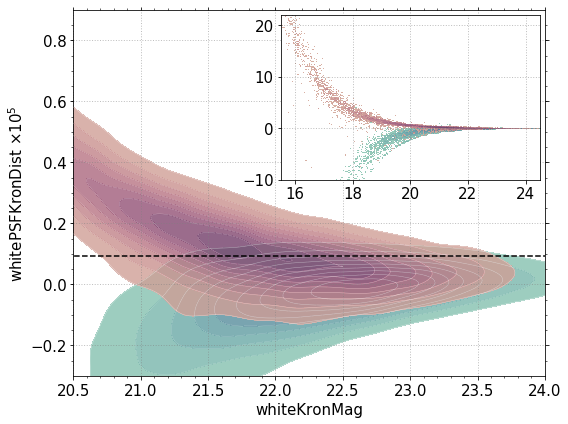

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fac=1e5

xlims = [20.5, 24]
ylims = np.array([-0.3e-5, 0.9e-5])*fac

cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))
axins = inset_axes(ax, width="55%",  
                   height="45%", loc=1)

ax.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
ax.tick_params(which="both", top=True, right=True)
ax.minorticks_on()

xgal_Dist, ygal_Dist, zgal_Dist = kde_contour_dat(whiteKronMag[mask&galaxy], ff_tab.wwPSFKronDist[mask&galaxy]*fac, 
                                                     grid_bins=200, extent=(20.5, 24.5, -0.3e-5*fac, 1e-5*fac), BW=[0.1, 5e-7*fac])
xstar_Dist, ystar_Dist, zstar_Dist = kde_contour_dat(whiteKronMag[mask&star], ff_tab.wwPSFKronDist[mask&star]*fac, 
                                                        grid_bins=200, extent=(20.5, 24.5,  -0.3e-5*fac, 1e-5*fac), BW=[0.1, 5e-7*fac])

ax.contourf(xgal_Dist, ygal_Dist, zgal_Dist, levels = levels,
             origin = origin,
             cmap = cmap_gal, alpha = 0.8)
ax.contour(xgal_Dist, ygal_Dist, zgal_Dist, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)
ax.contourf(xstar_Dist, ystar_Dist, zstar_Dist, levels = levels,  
               origin = origin,
               cmap = cmap_star, alpha = 0.8)
ax.contour(xstar_Dist, ystar_Dist, zstar_Dist, levels = levels,
                    linewidths=(0.5,), origin = origin,
                    colors = ("w",), alpha = 0.5, zorder = 11)  

ax.hlines(9.199338089095014e-07*fac, 10, 30,  colors='k', linestyles='dashed', linewidth=1.5, zorder=12)

ax.set_xlim(xlims); ax.set_ylim(ylims)
ax.tick_params(labelsize = 15)
ax.set_xlabel('whiteKronMag', fontsize=15)
ax.set_ylabel('whitePSFKronDist ×$10^5$', fontsize=15)

gridsize = 250
xlims = [15.5, 24.5]
ylims = np.array([-1e-4, 0.22e-3])*fac

origin = 'lower'
levels = np.arange(0.1, 1.1, 0.1)
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)
axins.grid(alpha=0.5, lw=1, c='grey', linestyle=':') 
#axins.tick_params(which="both", top=True, right=True)
#axins.minorticks_on()

axins.hist2d(whiteKronMag[mask&galaxy], ff_tab.wwPSFKronDist[mask&galaxy]*fac, 
            bins=[np.linspace(14.5, 24.5, gridsize), np.linspace(ylims[0], ylims[1], gridsize)], 
            norm=matplotlib.colors.LogNorm(), 
            cmap=cmap_gal, alpha=0.9)
axins.hist2d(whiteKronMag[mask&star], ff_tab.wwPSFKronDist[mask&star]*fac, 
            bins=[np.linspace(14.5, 24.5, gridsize), np.linspace(ylims[0], ylims[1], gridsize)], 
            norm=matplotlib.colors.LogNorm(), 
            cmap=cmap_star, alpha=0.9)

axins.set_yticks(np.arange(-10, 60, 10))
axins.set_xlim(xlims); axins.set_ylim(ylims)
axins.tick_params(labelsize = 15)
#plt.xlabel('whiteKronMag', fontsize=15)
#plt.ylabel('whitePSFMag', fontsize=15)
#plt.tight_layout()
#plt.savefig('whitePSFKronDistMini.pdf')

plt.tight_layout()
plt.savefig('whitePSFKronDist.pdf')